In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the Libraries and Dataset**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

 #Classification Models
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve
#decision tree
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
plt.style.use('seaborn-white')

#import csv file
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/bank.csv')

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
term_deposits = dataset.copy()

# **Data Inspection**

In [4]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
dataset.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


# Data **Cleaning**

In [7]:
def get_dummy_from_bool(row, column_name):
    #Returns 0 if value in column_name is no, returns 1 if value in column_name is yes
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
     #Returns mean value if value in column_name is above threshold
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    cleaned_df = df.copy()

    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)

    cleaned_df = cleaned_df.drop(columns = bool_columns)

    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)

    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])

    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)

    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])

    return cleaned_df

In [8]:
cleaned_df = clean_data(dataset)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,59,2343,5,1042,0,1,0,1,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1.0,0.0
1,56,45,5,1467,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1.0,0.0
2,41,1270,5,1389,0,1,0,1,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1.0,0.0
3,55,2476,5,579,0,1,0,1,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,1.0,0.0
4,54,184,5,673,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,2.0,0.0


# Applying Machine Learning

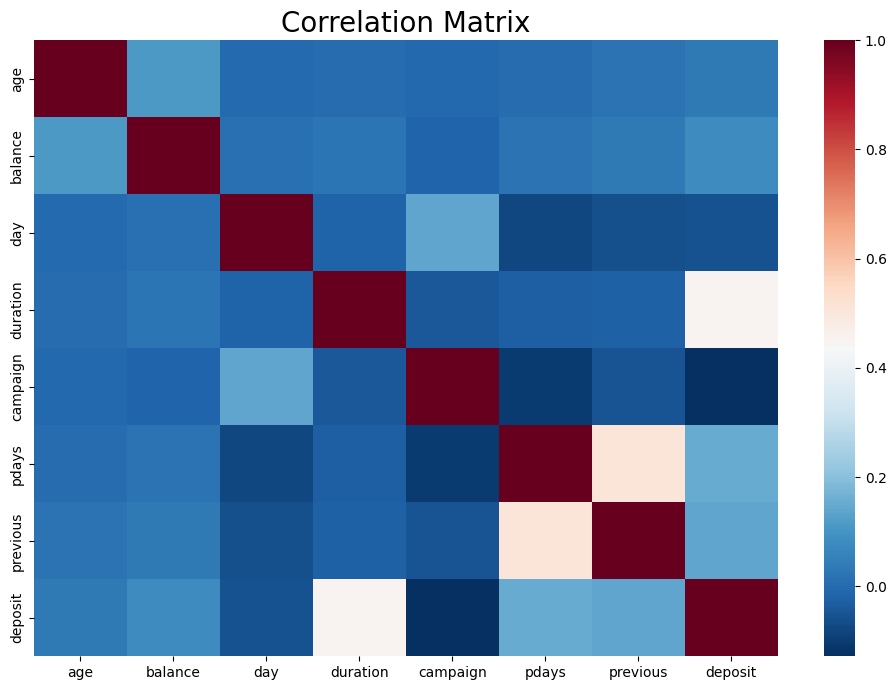

In [9]:
fig = plt.figure(figsize=(12,8))
dataset['deposit'] = LabelEncoder().fit_transform(dataset['deposit'])

# Separate both dataframes into
numeric_dataset = dataset.select_dtypes(exclude="object")
# categorical_df = df.select_dtypes(include="object")

corr_numeric = numeric_dataset.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=20)
plt.show()

Classification Model

In [10]:
dep = term_deposits['deposit']
term_deposits.drop(labels=['deposit'], axis=1,inplace=True)
term_deposits.insert(0, 'deposit', dep)
term_deposits.head()
term_deposits["housing"].value_counts()/len(term_deposits)

housing
no     0.526877
yes    0.473123
Name: count, dtype: float64

In [11]:
term_deposits["loan"].value_counts()/len(term_deposits)

loan
no     0.869199
yes    0.130801
Name: count, dtype: float64

In [12]:
#Splitting the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(term_deposits, term_deposits["loan"]):
    stratified_train = term_deposits.loc[train_set]
    stratified_test = term_deposits.loc[test_set]

stratified_train["loan"].value_counts()/len(dataset)
stratified_test["loan"].value_counts()/len(dataset)

loan
no     0.173894
yes    0.026160
Name: count, dtype: float64

In [13]:
# Separate the labels and the features.
train_data = stratified_train # Make a copy of the stratified training set.
test_data = stratified_test
train_data.shape
test_data.shape
train_data['deposit'].value_counts()

deposit
no     4697
yes    4232
Name: count, dtype: int64

In [15]:
# Application of the CategoricalEncoder class
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

#Fitting the CategoricalEncoder to X
    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

#Transform X using one-hot encoding
    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
# Set the problematic rows to an acceptable value and continue `The rows are marked `X_mask` and will be removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [16]:
# A class to select numerical or categorical columns since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8929 entries, 9867 to 9672
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deposit    8929 non-null   object
 1   age        8929 non-null   int64 
 2   job        8929 non-null   object
 3   marital    8929 non-null   object
 4   education  8929 non-null   object
 5   default    8929 non-null   object
 6   balance    8929 non-null   int64 
 7   housing    8929 non-null   object
 8   loan       8929 non-null   object
 9   contact    8929 non-null   object
 10  day        8929 non-null   int64 
 11  month      8929 non-null   object
 12  duration   8929 non-null   int64 
 13  campaign   8929 non-null   int64 
 14  pdays      8929 non-null   int64 
 15  previous   8929 non-null   int64 
 16  poutcome   8929 non-null   object
dtypes: int64(7), object(10)
memory usage: 1.2+ MB


In [18]:
# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign", "pdays", "previous","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month",
                                     "poutcome"])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [19]:
np.object = object
np.int = int
np.float = float
np.bool = bool
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [20]:
y_train = train_data['deposit']
y_test = test_data['deposit']
y_train.shape

(8929,)

In [21]:
encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)
y_train_yes = (y_train == 1)
y_train
y_train_yes

array([False, False,  True, ...,  True,  True, False])

In [22]:
some_instance = X_train[1250]

In [26]:
#Classification Models
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['Classifier', 'Train_score', 'Training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.process_time()
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'Train_score'] = train_score
        df_results.loc[count,'Training_time'] = t_diff
        if verbose:
            print("Trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

df_results = batch_classify(X_train, y_train)
print(df_results.sort_values(by='Train_score', ascending=False))

Trained Logistic Regression in 0.26 s
Trained Nearest Neighbors in 0.01 s
Trained Linear SVM in 3.51 s
Trained Gradient Boosting Classifier in 1.87 s
Trained Decision Tree in 0.09 s
Trained Random Forest in 0.22 s
Trained Neural Net in 9.88 s
Trained Naive Bayes in 0.02 s
                     Classifier  Train_score  Training_time
4                 Decision Tree     1.000000       0.085860
5                 Random Forest     0.997648       0.217035
2                    Linear SVM     0.881958       3.509946
1             Nearest Neighbors     0.863255       0.006778
3  Gradient Boosting Classifier     0.861463       1.867198
6                    Neural Net     0.853847       9.882170
0           Logistic Regression     0.830776       0.264721
7                   Naive Bayes     0.721693       0.016946


# **Cross Validation**

In [27]:
# Use Cross-validation.
# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = neural_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'],
    'Cross Validation Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

result_df = result_df.sort_values(by=['Cross Validation Mean Scores'], ascending=False)
result_df

,Classifiers,Cross Validation Mean Scores
1,SVC,0.851831
6,Neural Classifier,0.848695
7,Naives Bayes,0.848695
4,Grad B CLF,0.844552
5,Rand FC,0.839511
0,Logistic Reg.,0.828536
2,KNN,0.804569
3,Dec Tree,0.785418


# **Confusion Matrix**

In [28]:
# Cross validate our Gradient Boosting Classifier
y_train_pred = cross_val_predict(grad_clf, X_train, y_train, cv=3)

grad_clf.fit(X_train, y_train)
print ("Gradient Boost Classifier accuracy is %2.2f" % accuracy_score(y_train, y_train_pred))

Gradient Boost Classifier accuracy is 0.84


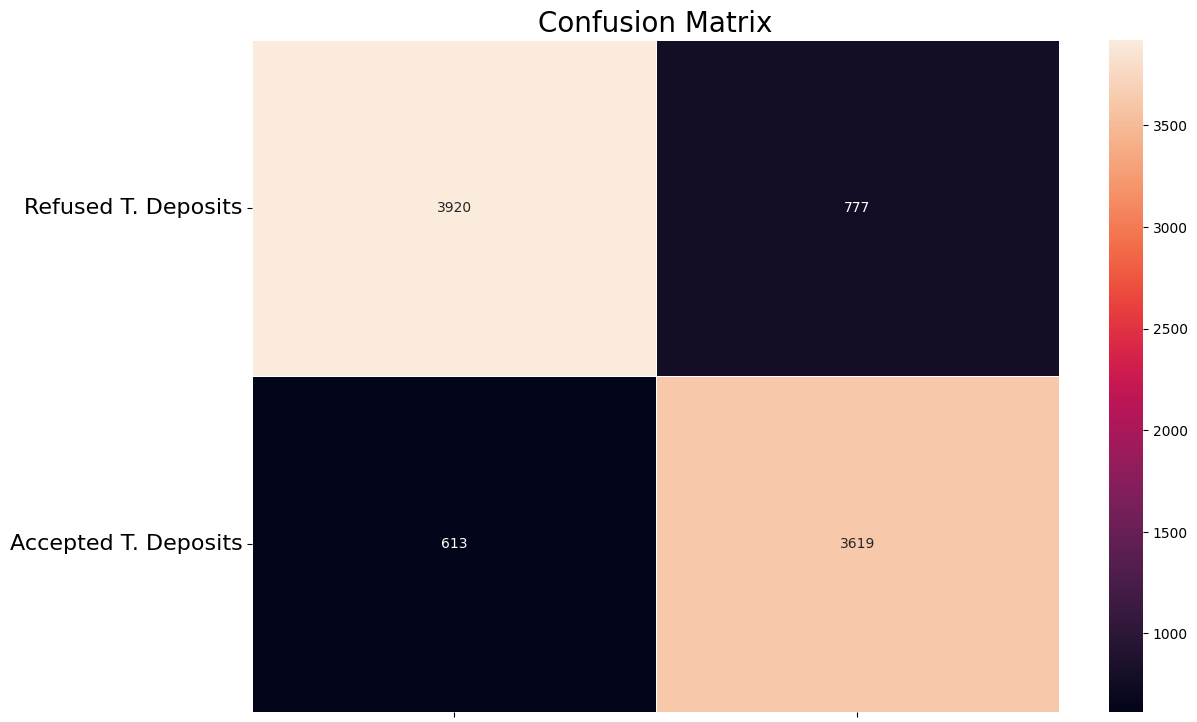

In [29]:
from sklearn.metrics import confusion_matrix
# 4697: no's, 4232: yes
conf_matrix = confusion_matrix(y_train, y_train_pred)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()

# **Precision, Recall, & F1 Score**

In [30]:
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
print('F1 Score: ', f1_score(y_train, y_train_pred))

Precision Score:  0.8232484076433121
Recall Score:  0.8551512287334594
F1 Score:  0.838896615669912


In [31]:
y_scores = grad_clf.decision_function([some_instance])
y_scores

array([-3.65645629])

In [32]:
# Increasing the threshold decreases the recall.
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_scores = cross_val_predict(grad_clf, X_train, y_train, cv=3, method="decision_function")
neural_y_scores = cross_val_predict(neural_clf, X_train, y_train, cv=3, method="predict_proba")
naives_y_scores = cross_val_predict(nav_clf, X_train, y_train, cv=3, method="predict_proba")

In [34]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

if neural_y_scores.ndim == 2:
    neural_y_scores = neural_y_scores[:, 1]

if naives_y_scores.ndim == 2:
    naives_y_scores = naives_y_scores[:, 1]

y_scores.shape

(8929,)

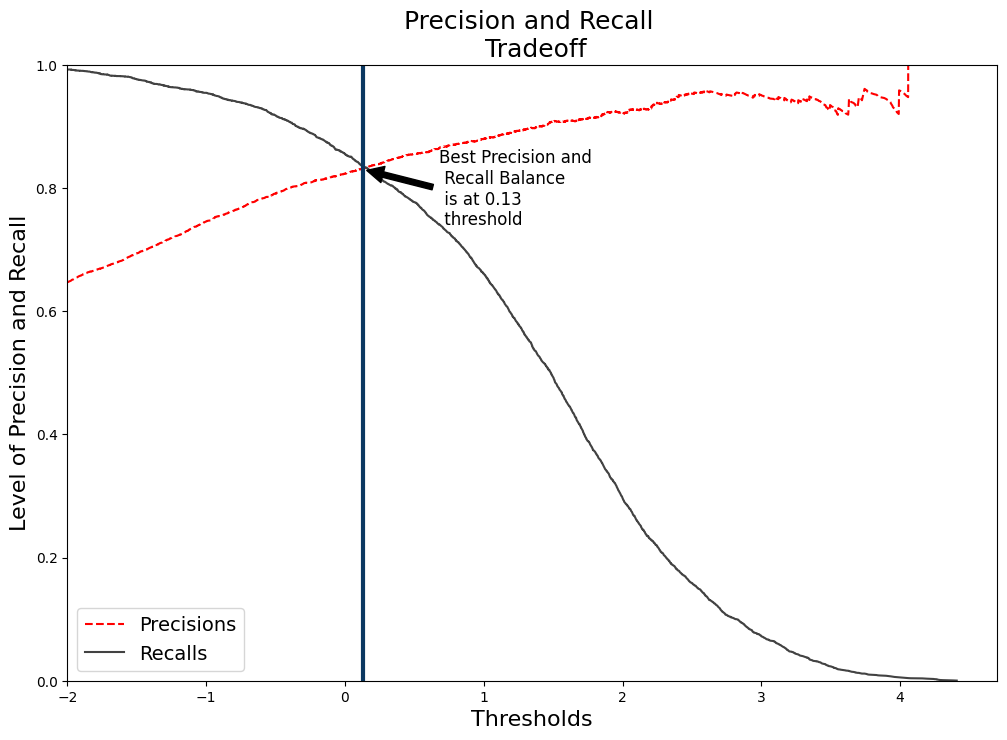

In [35]:
precisions, recalls, threshold = precision_recall_curve(y_train, y_scores)

def precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], "r--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "#424242", label="Recalls")
    plt.title("Precision and Recall \n Tradeoff", fontsize=18)
    plt.ylabel("Level of Precision and Recall", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.legend(loc="best", fontsize=14)
    plt.xlim([-2, 4.7])
    plt.ylim([0, 1])
    plt.axvline(x=0.13, linewidth=3, color="#0B3861")
    plt.annotate('Best Precision and \n Recall Balance \n is at 0.13 \n threshold ', xy=(0.13, 0.83), xytext=(55, -40),
             textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12,
                color='k')

precision_recall_curve(precisions, recalls, threshold)
plt.show()

# **ROC Curve (Receiver Operating Characteristic)**

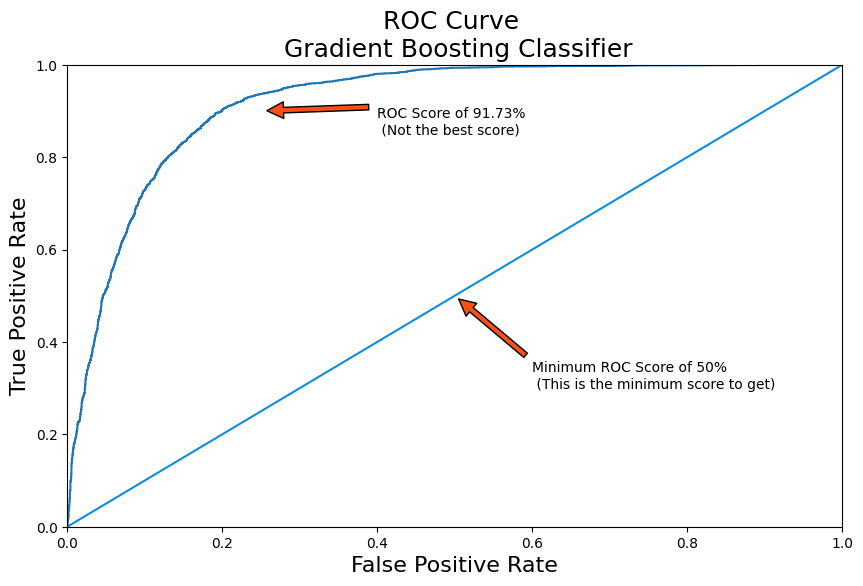

In [38]:
# Gradient Boosting Classifier
# Neural Classifier
# Naives Bayes Classifier
grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_scores)
neu_fpr, neu_tpr, neu_threshold = roc_curve(y_train, neural_y_scores)
nav_fpr, nav_tpr, nav_threshold = roc_curve(y_train, naives_y_scores)

def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('ROC Curve \n Gradient Boosting Classifier', fontsize=18)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('ROC Score of 91.73% \n (Not the best score)', xy=(0.25, 0.9), xytext=(0.4, 0.85),
            arrowprops=dict(facecolor='#F75118', shrink=0.05),
            )
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )


graph_roc_curve(grd_fpr, grd_tpr, threshold)
plt.show()

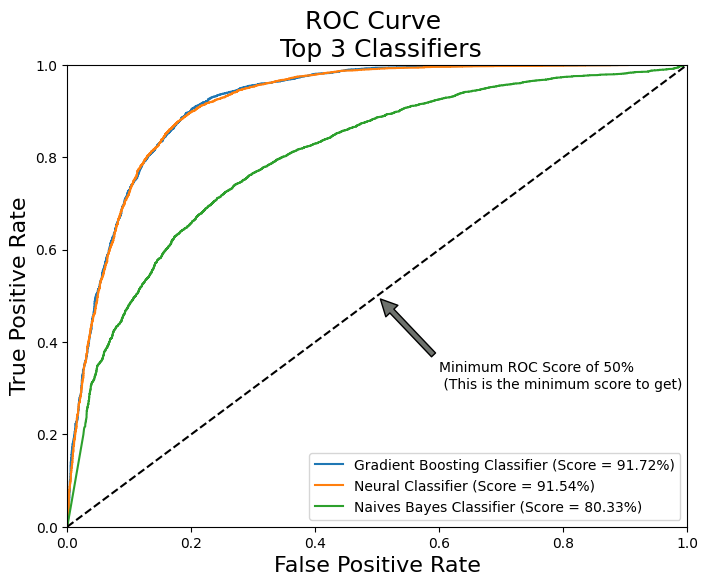

In [39]:
def graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score = 91.72%)')
    plt.plot(neu_fpr, neu_tpr, label='Neural Classifier (Score = 91.54%)')
    plt.plot(nav_fpr, nav_tpr, label='Naives Bayes Classifier (Score = 80.33%)')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr)
plt.show()

# **Decision Tree Classifier**

Feature ranking:
1. feature 11 (0.591310)
2. feature 8 (0.129966)
3. feature 6 (0.067020)
4. feature 13 (0.049923)
5. feature 15 (0.038138)
6. feature 14 (0.037830)
7. feature 10 (0.026646)
8. feature 5 (0.025842)
9. feature 0 (0.017757)
10. feature 12 (0.007889)
11. feature 3 (0.005280)
12. feature 9 (0.002200)
13. feature 2 (0.000147)
14. feature 1 (0.000050)
15. feature 7 (0.000000)
16. feature 4 (0.000000)


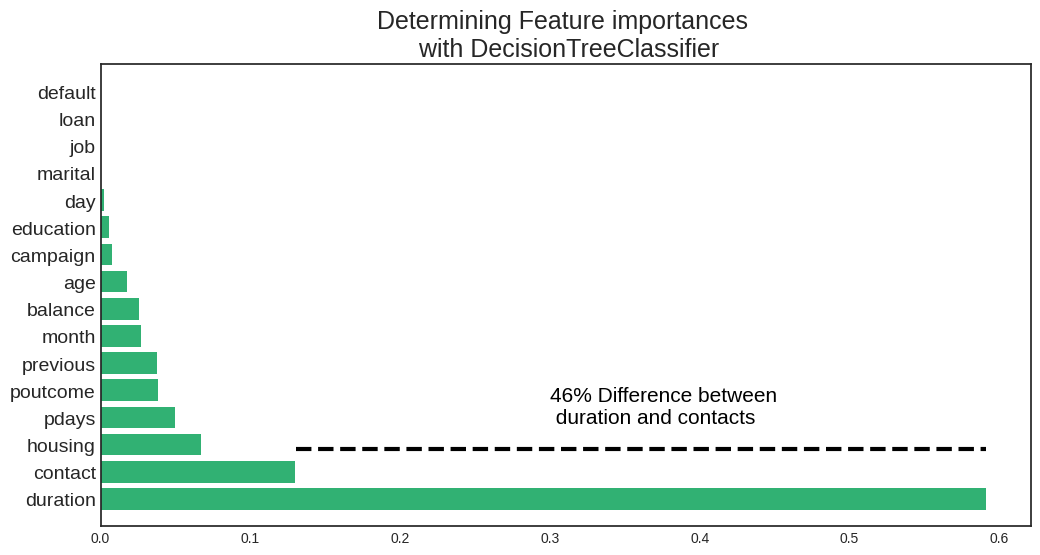

In [41]:
term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

# create new splittings but modified data was used.
# Create train and test splits
target_name = 'deposit'
X = term_deposits.drop('deposit', axis=1)


label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

# Build a classification task using 3 informative features
tree = tree.DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01

)


tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('deposit', axis=1).columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    plt.axhline(y=1.85, xmin=0.21, xmax=0.952, color='k', linewidth=3, linestyle='--')
    plt.text(0.30, 2.8, '46% Difference between \n duration and contacts', color='k', fontsize=15)

feature_importance_graph(indices, importances, feature_names)
plt.show()

In [42]:
voting_clf = VotingClassifier(
    estimators=[('gbc', grad_clf), ('nav', nav_clf), ('neural', neural_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (grad_clf, nav_clf, neural_clf, voting_clf):
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, predict))

GradientBoostingClassifier 0.8463949843260188
GaussianNB 0.7514554411106136
MLPClassifier 0.6798029556650246
VotingClassifier 0.8007165248544559


# **Conclusion**

The Classifiers I used are 8, they are Logistic Regression, SVC, KNN, Decision Tree, Gradient Boosting Classifier, Random Forest Classifier, Neural Net Classifier, and Naive Bayes.

Based on the result, it shows that Decision Tree got the highest Training Score with 1 and Training Time of 0.081. While Cross Validating, the Classifiers, it shows that SVC got the highest with 0.85 Cross Validation Score.

In calculating Gradient Boosting Classifier, Neural Classifier, and Naives Bayes, Classifier Receiver Operating Characteristic (ROC) is used. Based on the Result, Gradient Boosting Classifier got the highest with score of 0.85. Lastly, Gradient Boosting Classifier also got the highest in Voting Classifier using the accuracy score.